In [1]:
# https://www.tensorflow.org/guide/keras/transfer_learning
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://www.tensorflow.org/tutorials/images/data_augmentation
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
# https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=uk
# https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

#### Install packages

In [2]:
# These two packages allow use a pretrained ResNet-18 which is not natively implemented in tesorflow
!pip install image-classifiers==0.2.2
!pip install git+https://github.com/qubvel/classification_models

# This package contains cut-out
!pip install tensorflow_addons

     |████████████████████████████████| 81kB 3.7MB/s 
  Cloning https://github.com/qubvel/classification_models to /tmp/pip-req-build-e6v4hzq4
  Running command git clone -q https://github.com/qubvel/classification_models /tmp/pip-req-build-e6v4hzq4
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp37-none-any.whl size=20030 sha256=b9247fa4726eda805605cf34f1be624dbae626c08144bdb5b5e54205d1495cfd
  Stored in directory: /tmp/pip-ephem-wheel-cache-imuv0w7j/wheels/66/a9/a5/10d973a4500df4af06b6e1a417310ec68b8561c69b7a60f06a
Successfully built image-classifiers
  Found existing installation: image-classifiers 0.2.2
    Uninstalling image-classifiers-0.2.2:
      Successfully uninstalled image-classifiers-0.2.2
     |████████████████████████████████| 706kB 5.5MB/s 


In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from matplotlib import pyplot as plt
import numpy as np
import tarfile
import os
from classification_models.tfkeras import Classifiers

#### Import data

In [4]:
# download the .tgz containg the datasets
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof-320.tgz \
-O /tmp/imagewoof-320.tgz

# extract the data
tar_ref = tarfile.open('/tmp/imagewoof-320.tgz', 'r')
tar_ref.extractall('/tmp/')
tar_ref.close()

train_path = '/tmp/imagewoof-320/train'
val_path = '/tmp/imagewoof-320/val'

--2021-03-17 19:21:15--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.99.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.99.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328003750 (313M) [application/x-tar]
Saving to: ‘/tmp/imagewoof-320.tgz’

/tmp/imagewoof-320. 100%[===================>] 312.81M  16.4MB/s    in 20s     

2021-03-17 19:21:36 (15.4 MB/s) - ‘/tmp/imagewoof-320.tgz’ saved [328003750/328003750]



In [5]:
breed_labels = ['shih-tzu', 'rhodesian ridgeback', 'beagle', 'english foxhound', 
                'border terrie', 'australian terrier', 'golden retrieve',
                'old english sheepdog', 'samoyed', 'dingo']

In [6]:
# this function counts the number of instances for each class
def count_dogs(folder_path):
  dogs_count = {}
  labels = os.listdir(folder_path)
  dog_paths = sorted([os.path.join(folder_path, label) for label in labels])
  for dog_path, breed_label in zip(dog_paths, breed_labels):
    count = len(os.listdir(dog_path))
    dogs_count[breed_label] = count
  return dogs_count

In [7]:
train_count = count_dogs(train_path)
val_count = count_dogs(val_path)

In [9]:
train_count

{'australian terrier': 1300,
 'beagle': 1300,
 'border terrie': 1300,
 'dingo': 1300,
 'english foxhound': 754,
 'golden retrieve': 1300,
 'old english sheepdog': 1300,
 'rhodesian ridgeback': 1300,
 'samoyed': 1300,
 'shih-tzu': 1300}

The train set contains 1300 examples for each class, except for the "english foxhoud" which has only 754 instances

In [ ]:
val_count

{'australian terrier': 50,
 'beagle': 50,
 'border terrie': 50,
 'dingo': 50,
 'english foxhound': 50,
 'golden retrieve': 50,
 'old english sheepdog': 50,
 'rhodesian ridgeback': 50,
 'samoyed': 50,
 'shih-tzu': 50}

The validation set contains 50 images for each class

In [10]:
# This function creates a tensorflow dataset
def create_dataset(folder_path, shuffle=True):
  return tf.keras.preprocessing.image_dataset_from_directory(
    folder_path, labels='inferred', label_mode='categorical',
    color_mode='rgb', batch_size=32, image_size=(320, 320), shuffle=shuffle, seed=None,
    interpolation='bilinear')

In [11]:
train_ds = create_dataset(train_path, shuffle=True).prefetch(1)
val_ds = create_dataset(val_path, shuffle=True).prefetch(1)

Found 12454 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


#### Define random cutout layer

In [ ]:
# This function applies cut-out to a image with a certain probability set by the user
def cutout_img(image, size=100, prob=1.0):
  if np.random.uniform() < prob:
    image = tfa.image.cutout(
      image,
      constant_values=0.5,
      mask_size=[size, size],
      offset = (np.random.randint(0, 321), np.random.randint(0, 321)))
  
  return image

# this function implements cut-out into a lambda layer that can be used in a neural network
def cutout(size=100, prob=1.0, seed=None):
  np.random.seed(seed)
  return keras.layers.Lambda(lambda image: cutout_img(image, size, prob))

this implementation of cutout follows the suggestions described in the paper "Improved Regularization of Convolutional Neural Networks with Cutout" by DeVries and Tylor:
- portions of the mask are allowed to lay outside the borders of the image.
- the mask can be randomly applied to a subset on the images so that
the network sometimes receives unmodified images.

#### Visualize data

In [ ]:
#  takes the first 14 images and labels
for images, labels in train_ds.take(1):
 images = images[:14]
 labels = labels[:14]

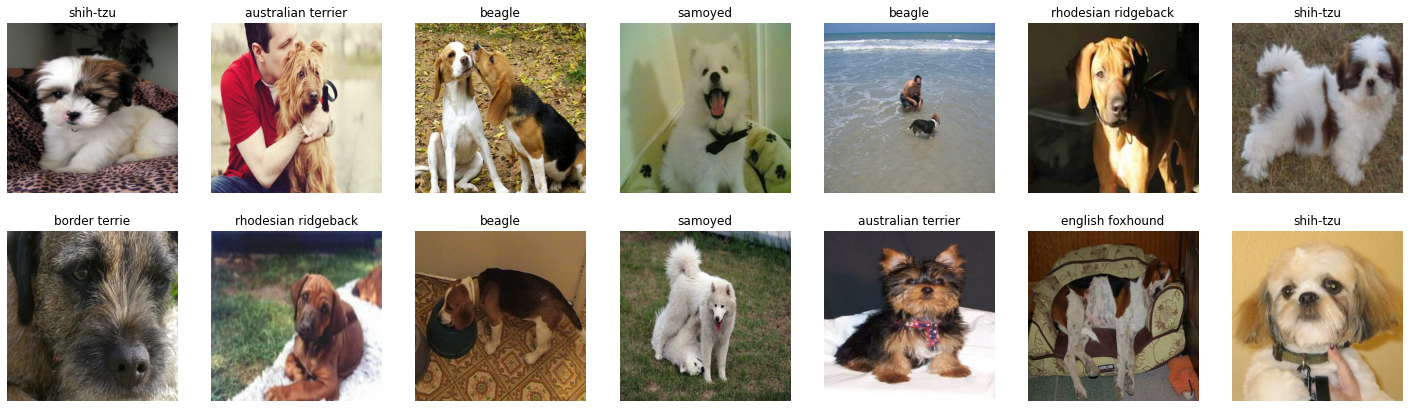

In [ ]:
# visualize some sample images
plt.figure(figsize=[25, 7])
for i, (image, label) in enumerate(zip(images, labels)):
  plt.subplot(2, 7, i+1)
  plt.imshow(image / 255.)
  plt.title(breed_labels[np.argmax(label)])
  plt.axis('off')
plt.show()

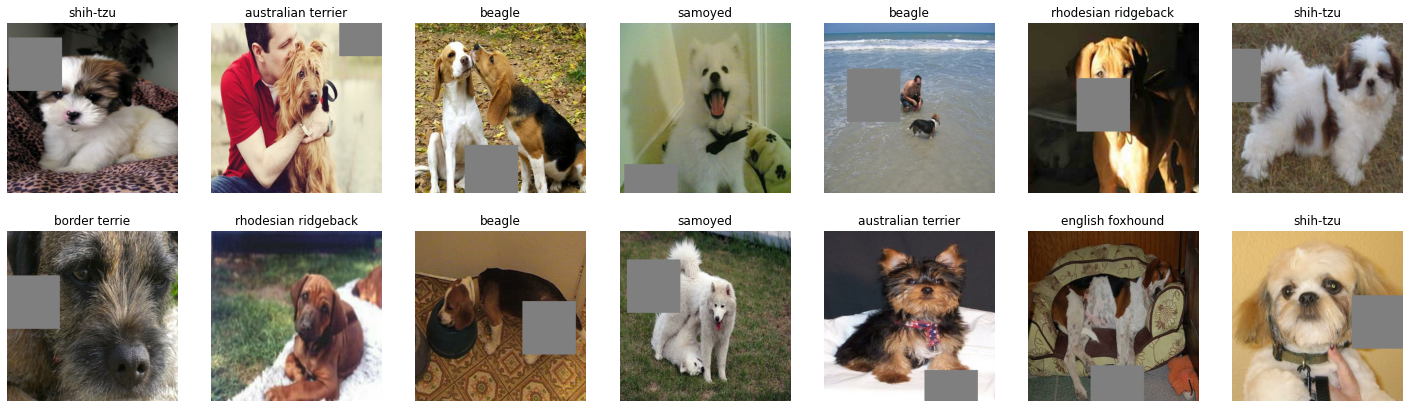

In [ ]:
# visualize sample images with cut-out
cutout_layer = cutout(size=100, prob=0.90, seed=100)
plt.figure(figsize=[25, 7])
for i, (image, label) in enumerate(zip(images, labels)):
  plt.subplot(2, 7, i+1)
  image_cutout = cutout_layer(tf.expand_dims(image / 255., axis=0))
  plt.imshow(tf.squeeze(image_cutout))
  plt.title(breed_labels[np.argmax(label)])
  plt.axis('off')
plt.show()

In [ ]:
# this function create a cnn based on a resnet-18 pretrained on imagenet
# the hidden layers are frozen to avoid disrupting the weights during the initial epochs
# on top of the model, a dense layer with 10 neurons and softmax activation function
#  was added as output layer
# the function returns also the base model in case the user wants to unfroze the layers
# and fine-tune the model
def create_model(mask_size, prob, seed=None):
  keras.backend.clear_session()

  ResNet18, preprocess_input = Classifiers.get('resnet18')
  base_model = ResNet18((320, 320, 3), weights='imagenet', include_top=False)
  base_model.trainable = False

  inputs = keras.Input(shape=(320, 320, 3))
  x = preprocess_input(inputs)
  x = cutout(size=mask_size, prob=prob, seed=seed)(x)
  x = base_model(x, training = False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  output = keras.layers.Dense(10, activation='softmax')(x)
  model = keras.models.Model(inputs=[inputs], outputs=[output])
  
  return model, base_model

# this function simply train the model
def train_model(model, epochs):
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

  return history

# this function unfreeze a specific number of layers set by the user
# the "n_layers" parameter indicates the number of layers to keep frozen
def finetune_model(model, base_model, epochs, n_layers):
  base_model.trainable = True

  for layer in base_model.layers[:n_layers]:
    layer.trainable = False

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

  return history

In [ ]:
# this function aggregates the creation, training and fine-tuning of the model
# and allows to iterate the process multiple times in order to get more reliable results
# the function returns the average accuracy and validation accuracy over the number of iterations
def run_model(mask_size, prob, tr_epochs, ft_epochs, n_iter, fixed_layers):
  acc = np.zeros([n_iter, tr_epochs + ft_epochs])
  val_acc = np.zeros([n_iter, tr_epochs + ft_epochs])
  
  for i in range(n_iter):
    print('Starting iteration {}'.format(i+1))
    print('Training')
    model, base_model = create_model(mask_size=mask_size, prob=prob)
    tr_history = train_model(model, tr_epochs)
    acc[i, :tr_epochs] = tr_history.history['accuracy']
    val_acc[i, :tr_epochs] = tr_history.history['val_accuracy']
    
    if ft_epochs:
      print('Fine-tuning')
      ft_history = finetune_model(model, base_model, ft_epochs, fixed_layers)
      acc[i, tr_epochs:] = ft_history.history['accuracy']
      val_acc[i, tr_epochs:] = ft_history.history['val_accuracy']
  
  avg_acc = np.mean(acc, axis=0)
  avg_val_acc = np.mean(val_acc, axis=0)
  
  return avg_acc, avg_val_acc

In [ ]:
# compute the average train and validation accuracy over 10 iterations without applying cutout to the training set
# at each iteration the model was trained for 5 epochs without unfreezing any layer.
acc_nomask, val_acc_nomask = run_model(mask_size=0, prob=0, tr_epochs=5, ft_epochs=0, n_iter=10, fixed_layers=80)

Starting iteration 1
Training
Epoch 1/5
390/390 [==============================] - 37s 92ms/step - loss: 0.9824 - accuracy: 0.7217 - val_loss: 0.3018 - val_accuracy: 0.9060
Epoch 2/5
390/390 [==============================] - 36s 91ms/step - loss: 0.2335 - accuracy: 0.9381 - val_loss: 0.2723 - val_accuracy: 0.9000
Epoch 3/5
390/390 [==============================] - 36s 91ms/step - loss: 0.1882 - accuracy: 0.9452 - val_loss: 0.2584 - val_accuracy: 0.9080
Epoch 4/5
390/390 [==============================] - 36s 92ms/step - loss: 0.1674 - accuracy: 0.9502 - val_loss: 0.2457 - val_accuracy: 0.9100
Epoch 5/5
390/390 [==============================] - 36s 92ms/step - loss: 0.1546 - accuracy: 0.9550 - val_loss: 0.2561 - val_accuracy: 0.9020
Starting iteration 2
Training
Epoch 1/5
390/390 [==============================] - 38s 92ms/step - loss: 0.9974 - accuracy: 0.7128 - val_loss: 0.3569 - val_accuracy: 0.8920
Epoch 2/5
390/390 [==============================] - 36s 92ms/step - loss: 0.2296 

In [ ]:
print('train accuracy no mask: {}'.format(acc_nomask))
print('validation accuracy no mask: {}'.format(val_acc_nomask))
print('overfitting: {}'.format(acc_nomask - val_acc_nomask))

train accuracy no mask: [0.85330817 0.93765056 0.94506986 0.94922917 0.95236068]
validation accuracy no mask: [0.902      0.90659999 0.90700001 0.90959999 0.9054    ]
overfitting: [-0.04869184  0.03105057  0.03806985  0.03962918  0.04696068]


On average the vanilla model achieved a validation accuracy of 90.50%, while the overfitting was around 4.7%

In [ ]:
# compute the average train and validation accuracy over 10 iterations using a mask of 60 x 60 pixels applied on average on 95% of the instances.
# at each iteration the model was trained for 5 epochs without unfreezing any layer.
acc_withmask, val_acc_withmask = run_model(mask_size=60, prob=0.95, tr_epochs=5, ft_epochs=0, n_iter=10, fixed_layers=80)

Starting iteration 1
Training
Epoch 1/5
390/390 [==============================] - 39s 94ms/step - loss: 1.0529 - accuracy: 0.6913 - val_loss: 0.3514 - val_accuracy: 0.8820
Epoch 2/5
390/390 [==============================] - 37s 94ms/step - loss: 0.2426 - accuracy: 0.9325 - val_loss: 0.2970 - val_accuracy: 0.8920
Epoch 3/5
390/390 [==============================] - 36s 92ms/step - loss: 0.1970 - accuracy: 0.9395 - val_loss: 0.2661 - val_accuracy: 0.9000
Epoch 4/5
390/390 [==============================] - 37s 92ms/step - loss: 0.1749 - accuracy: 0.9463 - val_loss: 0.2693 - val_accuracy: 0.9060
Epoch 5/5
390/390 [==============================] - 37s 94ms/step - loss: 0.1595 - accuracy: 0.9495 - val_loss: 0.2436 - val_accuracy: 0.9100
Starting iteration 2
Training
Epoch 1/5
390/390 [==============================] - 39s 95ms/step - loss: 1.0392 - accuracy: 0.7078 - val_loss: 0.3732 - val_accuracy: 0.8780
Epoch 2/5
390/390 [==============================] - 37s 93ms/step - loss: 0.2428 

In [ ]:
print('train accuracy no mask: {}'.format(acc_withmask))
print('validation accuracy no mask: {}'.format(val_acc_withmask))
print('overfitting: {}'.format(acc_withmask - val_acc_withmask))

train accuracy no mask: [0.83991488 0.92723623 0.93488036 0.93990687 0.94382527]
validation accuracy no mask: [0.89120001 0.896      0.8988     0.9012     0.90199999]
overfitting: [-0.05128513  0.03123623  0.03608037  0.03870686  0.04182528]


After several experimentations, the model with cutout achieved the best results with a mask between 50 x 50 and 80 x 80 pixels. In addition, allowing the model the possibilty to get a glimpse at some of the images without the mask seems to even further push the perfomances up.

Finetuning the model by unfreezing some of the layer on top of the model had the only effect to increase overfitting and for this reason was not applied during the final analysis.

In this case, the model with cutout reached a validation accuracy equal to 90.20%, reducing the overfitting to 4.2%

In [ ]:
def plot_acc(acc, val_acc, title, ax):
  ax.plot(range(len(acc)), acc, 'r', marker='o', label='train')
  ax.plot(range(len(acc)), val_acc, 'b', marker='o', label='validation')
  for index, (value_acc, value_val_acc) in enumerate(zip(acc, val_acc)): 
    ax.text(index, value_acc+5e-3, str(round(value_acc, 4)))
    ax.text(index, value_val_acc+5e-3, str(round(value_val_acc, 4)))
  ax.set_xticks(range(len(acc)+1))
  ax.set_xticklabels(range(1, len(acc)+2))
  ax.set_yticks([0.83, 0.85, 0.90, 0.95, 0.98])
  ax.set_xlabel('epochs')
  ax.set_ylabel('accuracy')
  ax.grid()
  plt.title(title)
  ax.legend(loc=4)

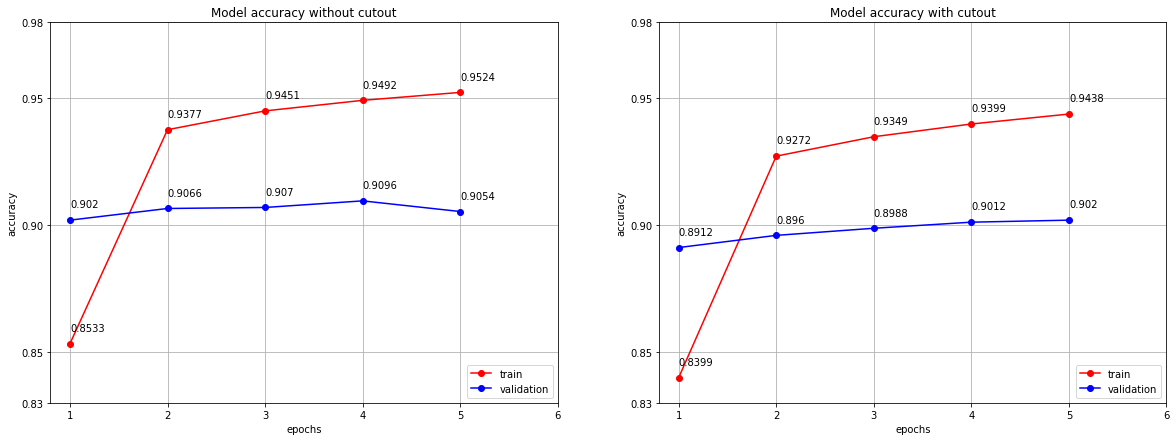

In [ ]:
metrics = [[acc_nomask, val_acc_nomask, 'Model accuracy without cutout'],
           [acc_withmask, val_acc_withmask, 'Model accuracy with cutout']]

plt.figure(figsize=[20, 7])
for i in range(2):
  ax = plt.subplot(1, 2, i+1)
  plot_acc(metrics[i][0], metrics[i][1], metrics[i][2], ax)
plt.show()

The  plot on the left side compares the average train and validation accuracy without applying cutout over 10 iterations, while the plot on the right side shows the performance of the model with cutout. 
In this case, the plot on the right shows the performances of a model applying a 60 x 60 mask to 95% of the training instances.
In general, both models reach comparable perfomances to the ones present in the [leaderboard](https://github.com/fastai/imagenette#imagewoof-leaderboard).
As expected, the performances of the model with cutout are slightly worse than the first model, but it also shows less overfitting.

#### Error analysis

In [ ]:
#train a single model to perform error analysis
model, base_model = create_model(mask_size=60, prob=0.95, seed=100)
history = train_model(model, epochs=5)

Epoch 1/5
390/390 [==============================] - 55s 98ms/step - loss: 1.0794 - accuracy: 0.6841 - val_loss: 0.3270 - val_accuracy: 0.8920
Epoch 2/5
390/390 [==============================] - 38s 96ms/step - loss: 0.2452 - accuracy: 0.9315 - val_loss: 0.2920 - val_accuracy: 0.8920
Epoch 3/5
390/390 [==============================] - 38s 96ms/step - loss: 0.1985 - accuracy: 0.9419 - val_loss: 0.2635 - val_accuracy: 0.9040
Epoch 4/5
390/390 [==============================] - 38s 96ms/step - loss: 0.1789 - accuracy: 0.9455 - val_loss: 0.2696 - val_accuracy: 0.9000
Epoch 5/5
390/390 [==============================] - 38s 96ms/step - loss: 0.1644 - accuracy: 0.9494 - val_loss: 0.2498 - val_accuracy: 0.9100


In [ ]:
# create a validation set with no shuffle to extract the images and labels
val_ds_noshuffle = create_dataset(val_path, shuffle=False)

Found 500 files belonging to 10 classes.


In [ ]:
# check that the two validation sets return the same perfomances
print(model.evaluate(val_ds, verbose=0))
print(model.evaluate(val_ds_noshuffle, verbose=0))

[0.24979472160339355, 0.9100000262260437]
[0.24979470670223236, 0.9100000262260437]


In [ ]:
# extract the images and labels from the validation set
X_val = np.concatenate([x for x, y in val_ds_noshuffle], axis=0)
y_val = np.concatenate([y for x, y in val_ds_noshuffle], axis=0)

# apply ordinal encoding
y_val_label = np.argmax(y_val, axis=1)

In [ ]:
# predict labels and apply ordinal encoding
y_pred_label = np.argmax(model.predict(val_ds_noshuffle), axis=1)

In [ ]:
# indentify mislabeled images
mislabeled_index = (y_val_label != y_pred_label)

In [ ]:
# count mislabeled images
sum(mislabeled_index)

51

In [ ]:
# extract images, true and predicted labels
X_val_mislab = X_val[mislabeled_index]
y_val_mislab_true = y_val_label[mislabeled_index]
y_val_mislab_pred = y_pred_label[mislabeled_index]

In [ ]:
# create dataset for visualization
val_mislab_ds = tf.data.Dataset.from_tensor_slices((X_val_mislab, list(zip(y_val_mislab_true, y_val_mislab_pred))))

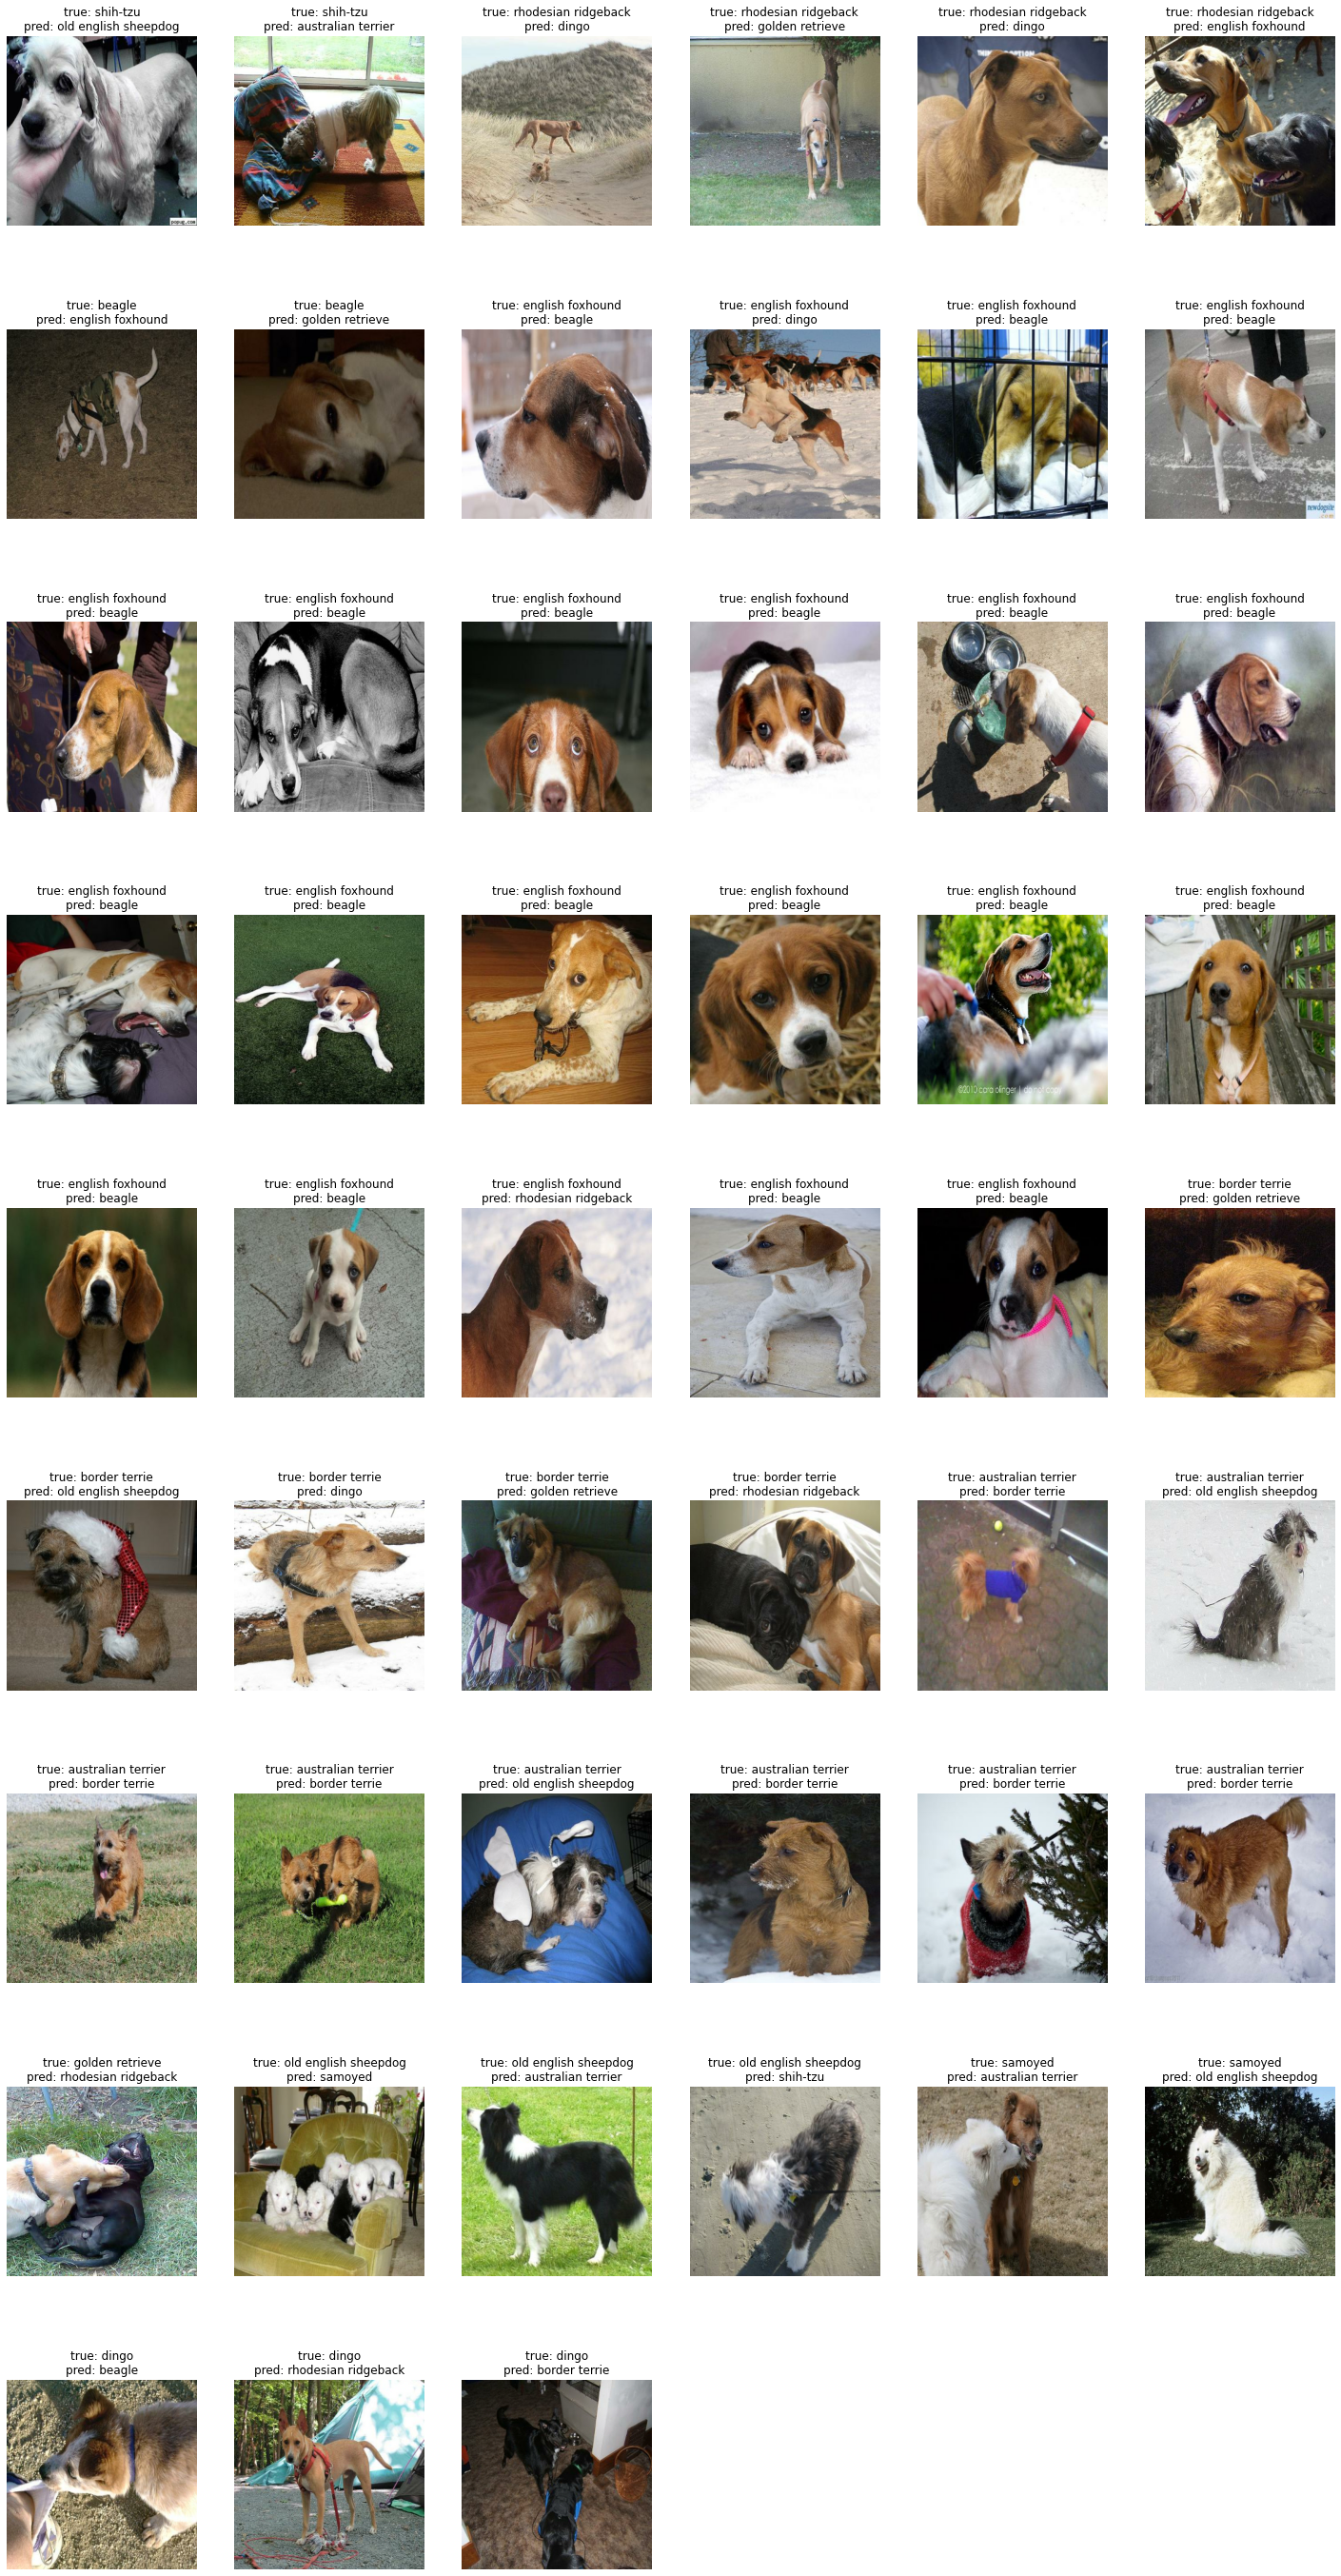

In [ ]:
# create dataset for visualization
val_mislab_ds = tf.data.Dataset.from_tensor_slices((X_val_mislab, list(zip(y_val_mislab_true, y_val_mislab_pred))))

# visualize images
plt.figure(figsize=[25, 50])
for i, (image, label) in enumerate(val_mislab_ds.take(52)):
  plt.subplot(9, 6, i+1)
  plt.imshow(image / 255.)
  plt.title('true: {}\npred: {}'.format(breed_labels[label[0]], breed_labels[label[1]]))
  plt.axis('off')
plt.show()

In [ ]:
# counts how many time each class in the validation set was misclassified
count_misclf_bydog = {}
for i in range(10):
  count = np.count_nonzero(y_val_mislab_true == i)
  count_misclf_bydog[breed_labels[i]] = count

count_misclf_bydog

{'australian terrier': 8,
 'beagle': 2,
 'border terrie': 5,
 'dingo': 3,
 'english foxhound': 21,
 'golden retrieve': 1,
 'old english sheepdog': 3,
 'rhodesian ridgeback': 4,
 'samoyed': 2,
 'shih-tzu': 2}

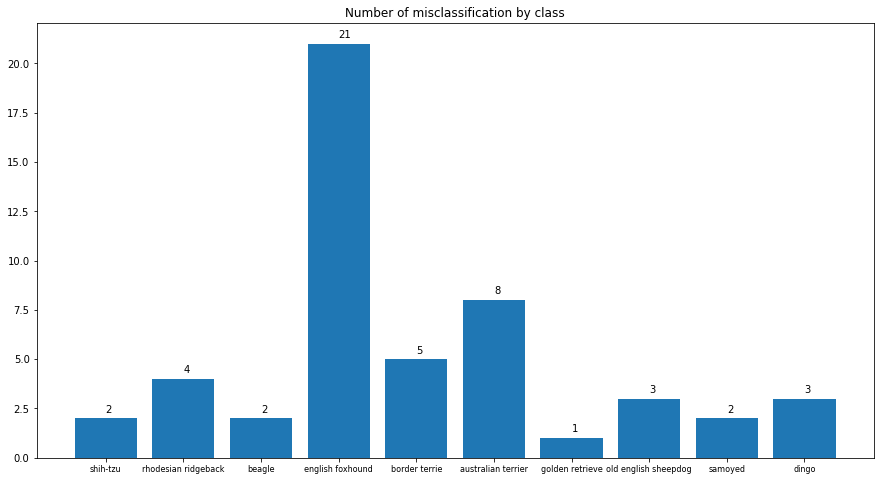

In [ ]:
fig, ax = plt.subplots(figsize=[15, 8])
plt.bar(count_misclf_bydog.keys(), count_misclf_bydog.values())
for i, value in enumerate(count_misclf_bydog.values()):
  ax.text(i, value+0.3, str(value))
ax.tick_params(axis='x', which='major', labelsize=8)
plt.title('Number of misclassifications by class')
plt.show()

In [ ]:
# beagle --> class 2
# english foxhound --> class 3

# counts how many times the english fox hound was classified as beagle
count = 0
for (y_true, y_pred) in zip(y_val_mislab_true, y_val_mislab_pred):
  if (y_true, y_pred) == (3, 2):
    count += 1

count

19

The bar chart shows that the most frequently misclassified class was the English foxhoud followed by the Australian terrier. Specifically, in 19 cases out of 21 the English foxhound was mistaken for a beagle. This result is not suprising since the two breeds of dog have a similar appearance. The main difference in a foxhound and beagle physically is their size. In fact, the foxhound is much bigger than the beagle. However, as the result shows the cnn does not seem to learn well the size factor. This aspect might explain why applying cutout has little benefits on the model perfomances.

Furthermore, the reason why the english foxhound is consistently mistaken for a beagle and not the other way around might be due to the fact that the foxhound is the only class in the training set to be slightly underrepresented.

In conclusion, the application of cutout on the imagewoof dataset didn't seem to generate enough improvements to justify its implementation. In fact, the basic Resnet-18 pretrained on Imagenet is able to reach state-of-the-art performances (about 91% validation accuracy) in only 5 epochs with already small overfitting. Based on the error analysis, the lower accuracy achieved by the model regardless the application of cutout seems more related to intrinsic characteristics of same of the images (similarities between beagle and foxhound) that makes them particularly difficult to classify correctly. Possible solution that might contribute to solve this problem might be:
- merge beagle and foxhound in one class
- apply different types of image augmentation
- perform random oversampling of foxhound in the training set